> 7장. 여러개 분류

### 7.1 다중 분류 신경망 만들기

In [1]:
import numpy as np

In [41]:
class MultiClassNetwork:
    def __init__(self, units=10, batch_size=32, learing_rate=0.1, l1=0, l2=0):
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size #배치크기
        self.w1 = None #은닉층의 가중치
        self.b1 = None #은닉층의 절편
        self.w2 = None #출력층의 가중치
        self.b2 = None #출력층의 절편
        self.losses = [] #훈련 손실
        self.val_losses = [] # 검증손실
        self.lr = learing_rate #학습률
        self.l1 = l1 # L1 손실 하이퍼파라미터
        self.l2 = l2 # L2 손실 하이퍼파라미터
    
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1 # 첫번째 층의 선형 식을 계산
        self.a1 = self.sigmoid(z1) #활성화 함수를 적용
        z2 = np.dot(self.a1, self.w2) + self.b2 # 두 번째 층의 선형 식을 계산
        return z2

    def backprop(self, x, err):
        m = len(x) #샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트 계산
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트 계산
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트 계산
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def sigmoid(self,z):
        z = np.clip(z, -100, None)  # 안전한 np.exp() 계산을 위함
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
    
    def softmax(self, z):
        #소프트맥스 함수
        z = np.clip(z, -100, None)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
    
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1,
                                   (n_features, self.units)) # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)   # 은닉층의 크기
        self.w2 = np.random.normal(0, 1,
                                   (self.units, n_classes))  # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])  # 은닉층과 출력층의 가중치를 초기화
        # epochs만큼 반복
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 구제 손실을 더하여 리스트 추가
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_loss(x_val, y_val)

    # a미니 배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

            
    

In [48]:
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.8.0'

In [5]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


> print(x_train_all.shape, y_train_all.shape)에서 출력된 결과 (60000, 28, 28)과 (60000,)는 두 데이터 배열 x_train_all과 y_train_all의 형태(shape)를 나타냅니다.

> (60000, 28, 28): x_train_all는 3차원 배열이며, 이 형태는 60000개의 28x28 크기의 이미지로 구성되어 있음을 의미합니다. 여기서 60000은 이미지의 개수, 28x28은 각 이미지의 높이와 너비를 나타냅니다. 즉, 각 이미지는 28행 28열의 픽셀로 이루어져 있습니다.

> (60000,): y_train_all는 1차원 배열이며, 60000개의 항목을 포함하고 있습니다. 각 항목은 x_train_all의 해당 이미지의 라벨을 나타냅니다.

> 예를 들어 패션 MNIST 데이터셋에서는: x_train_all은 60000개의 28x28 픽셀의 그레이스케일 이미지로 구성된 훈련 이미지 데이터입니다.

> y_train_all은 해당 이미지의 카테고리 라벨(0부터 9까지의 정수)를 포함하는 훈련 라벨 데이터입니다.

> 따라서 이 정보를 바탕으로 x_train_all[0]은 첫 번째 이미지의 28x28 픽셀 데이터를, y_train_all[0]은 첫 번째 이미지의 라벨을 나타냅니다.

In [7]:
import matplotlib.pyplot as plt

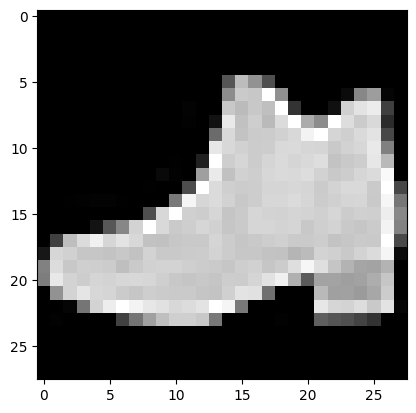

In [9]:
plt.imshow(x_train_all[15], cmap='gray')
plt.show()

In [10]:
print(y_train_all[:10])  #라벨링된거 확인

[9 0 0 3 0 2 7 2 5 5]


In [11]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [15]:
print(class_names[y_train_all[10]])

티셔츠/윗도리


In [16]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64)

In [17]:
from sklearn.model_selection import train_test_split

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [21]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800],
      dtype=int64)

In [23]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200],
      dtype=int64)

In [25]:
x_train = x_train / 255
x_val = x_val / 255

> x_train = x_train / 255와 x_val = x_val / 255로 데이터를 255로 나누는 것은 이미지 데이터를 정규화하는 표준적인 방법 중 하나입니다.

> 이미지 데이터는 보통 각 픽셀의 강도를 0에서 255 사이의 정수로 나타냅니다. 여기서 0은 검은색을, 255는 흰색을 의미하며, 그 사이의 값은 다양한 그레이스케일 값을 의미합니다 (컬러 이미지의 경우 RGB 각 채널마다 동일한 범위를 갖습니다).

> 255로 나눔으로써 데이터를 0과 1 사이의 범위로 스케일링하게 됩니다. 이러한 정규화는 다음과 같은 이유로 중요합니다:

> 신경망 학습의 안정성: 머신러닝 모델, 특히 딥러닝 모델은 입력 데이터의 스케일에 민감합니다. 0과 1 사이의 작은 값을 가지는 입력 데이터는 모델의 학습을 안정화시키고 더 빠르게 수렴하게 합니다.

> 가중치 초기화: 많은 딥러닝 모델의 가중치 초기화 방식은 0과 1 사이의 입력 데이터를 가정하고 설계되었습니다.

> 활성화 함수: 여러 활성화 함수 (예: 시그모이드)는 0과 1 사이의 값에 최적화되어 있습니다. 입력 데이터의 스케일이 너무 크면 활성화 함수의 출력이 해당 함수의 한계값에 빠르게 포화될 수 있습니다.

> 수치 안정성: 일관된 스케일의 데이터는 수치 연산에서의 오류나 불안정성을 줄일 수 있습니다.

In [26]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [27]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [31]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit_transform([0, 1, 3, 1])  # 원핫인코딩 / 0, 1, 3 을 각각 원핫인코딩하는것 

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [32]:
tf.keras.utils.to_categorical([0,1,3]) # 케라스 원핫인코딩

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [33]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [34]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [52]:
fc = MultiClassNetwork(units=100, batch_size=256) 
# `MultiClassNetwork` 클래스를 사용하여 다중 클래스 신경망을 생성합니다.
# 이 신경망은 100개의 유닛과 배치 크기 256을 가집니다.
fc.fit(x_train, y_train_encoded,
       x_val=x_val, y_val=y_val_encoded, epochs=40)
# 신경망을 훈련 데이터 `x_train` 및 `y_train_encoded`로 학습시킵니다.
# `x_val` 및 `y_val_encoded`는 검증 데이터로 사용됩니다.
# 신경망은 총 40 에포크 동안 학습됩니다.

........................................

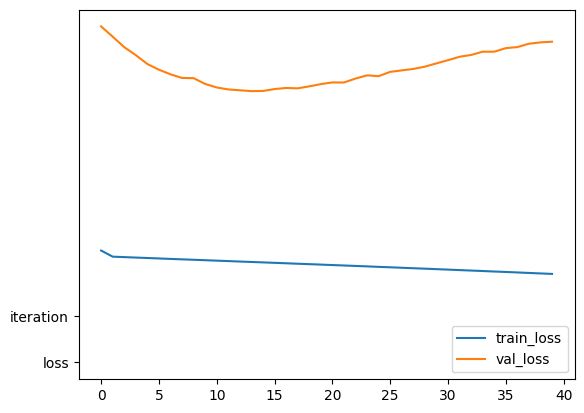

In [53]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.plot('loss')
plt.plot('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()


In [54]:

fc.score(x_val, y_val_encoded)

0.3555833333333333

In [56]:
np.random.permutation(np.arange(12000)%10)


array([3, 0, 3, ..., 1, 5, 7], dtype=int32)

> np.arange(12000) % 10:

> np.arange(12000)는 0부터 11999까지의 정수 배열을 생성합니다.

> % 10 연산은 각 원소를 10으로 나눈 나머지를 계산합니다. 따라서 결과 배열은 0부터 9까지의 숫자들이 1200번 반복되는 형태가 됩니다.

> 예: [0, 1, 2, ..., 9, 0, 1, 2, ..., 9, ...] (이 패턴이 총 1200번 반복됨)

> np.random.permutation(...):

> 이 함수는 주어진 배열을 무작위로 섞습니다.

>결과적으로 array([4, 6, 3, ..., 0, 6, 6], dtype=int32)는 0부터 9까지의 숫자들이 반복되는 배열을 무작위로 섞은 것

> 라벨이나 데이터를 무작위로 섞을 때 사용 / 0부터 9까지의 숫자들이 균등하게 분포되어 있지만 무작위 순서로 배열


In [57]:
np.sum(y_val == np.random.permutation(np.arange(12000)%10)) / 12000

0.10416666666666667

이 코드는 y_val 배열의 라벨과 0부터 9까지의 무작위 순열을 가진 배열 간의 일치도를 계산하는 것입니다. 구체적으로 코드를 단계별로 살펴보겠습니다.

np.random.permutation(np.arange(12000) % 10):

0부터 11999까지의 정수 배열을 생성한 다음, 각 원소를 10으로 나눈 나머지를 계산합니다. 결과적으로, 0부터 9까지의 숫자들이 1200번 반복되는 배열이 생성됩니다.
생성된 배열을 무작위로 섞습니다.
y_val == np.random.permutation(np.arange(12000) % 10):

y_val 배열과 위에서 생성한 무작위 배열을 원소별로 비교합니다. 두 배열의 같은 위치에 있는 원소가 동일하면 True, 그렇지 않으면 False를 반환합니다.
np.sum(...):

True는 1로, False는 0으로 간주되므로, np.sum()은 True의 개수, 즉 두 배열에서 일치하는 원소의 개수를 반환합니다.
np.sum(...) / 12000:

전체 원소 12000개 중에서 일치하는 원소의 비율을 계산합니다. 이 값은 두 배열 간의 일치도를 나타냅니다.
코드의 전반적인 의미는, y_val 배열의 라벨이 0부터 9까지의 숫자로 이루어진 무작위 배열과 얼마나 일치하는지를 계산하는 것입니다. 이런 연산을 통해, 만약 y_val이 무작위로 라벨링된 데이터라면, 일치도는 대략 10% (즉, 1/10) 근처의 값을 가질 것으로 예상됩니다

### 07-2 텐서플로와 케라스

In [58]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [59]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [60]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrices=['accuracy'])

TypeError: Invalid keyword argument(s) in `compile()`: ({'metrices'},). Valid keyword arguments include "cloning", "experimental_run_tf_function", "distribute", "target_tensors", or "sample_weight_mode".